## Yum or Yuck Butterfly Mimics 2022 – Baseline Model

**Author:** [Keith Pinson](https://github.com/keithpinson)<br>
**Date created:** 2022/06/11<br>
**Version:** 1.0.0001<br>
**Description:** A simple transfer learning model to establish a baseline score for a Kaggle Community Competition where we try to classify the name of the butterfly in each given image.<br>
**Platform:** Kaggle Packages including Tensorflow 2.6.3 with GPU support<br>
<br>

![Butterfly Classification Diagram](DocResources/ButterflyClassificationTransferLearning-854.png)

We will use the pre-trained weights of the EfficientNet convolutional neural network with the Imagenet dataset.  The final classification layers will be replaced with our own dense layers to make the butterfly classifier. We will not do any fine-tuning of the pre-trained model.

In [1]:
import datetime

print("executed",datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),"local time")

executed 2022-07-09 08:27:57 local time


---
Using TensorFlow we will a build a butterfly image classifier that will be able to identify 6 remarkable North American butterflies. The Monarch and Pipevine caterpillars sequester toxins: cardiac glycoside and aristolochic acid, from their host plants as they feed. Birds find these butterflies distasteful. They are yucky. The other butterflies mimic the Monarch or Pipevine butterflies and are yummy. Well, except for the Viceroy, since it is both yucky and a mimic, as it sequesters salicylic acid when a caterpillar.

Our goal is to accurately identify the butterflies by name.

![Images of Black, Monarch, Pipevine, Spicebush, Tiger and Viceroy butterflies from the dataset](DocResources/the-butterflies.png)

<br>
This notebook will:

 - Load EfficientNet with the pre-trained Imagenet weights
 - Load the Butterfly Mimics dataset
 - Create a new set of feature weights using our own classifier
 - Predict the butterflies from the test
 - Show a sample of the results
 - Quantify the accuracy of the results



---
## Set Hyperparameters
---

In [2]:
# Hyper-parameters
LEARNING_RATE = 0.0003
NUMBER_OF_EPOCHS = 20

# Other constants
IMAGE_WIDTH = IMAGE_HEIGHT = 224
IMAGE_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)  # Rows, Columns order
IMAGE_DEPTH = 3
BATCH_SIZE = 64
BUFFER_SIZE = 1024
MODEL_NAME = 'yoymimics'

SEED = 43

##
---
## Set Environment
---


In [4]:
import os
import random

import tensorflow as tf

from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

# Using TensorFlow's enhanced version of Numpy
import tensorflow.experimental.numpy as np
np.experimental_enable_numpy_behavior()

AUTOTUNE = tf.data.experimental.AUTOTUNE

import pandas as pd
import matplotlib.pyplot as plt

import IPython.display as display

from keras.callbacks import EarlyStopping
from keras.layers import \
    Activation, \
    BatchNormalization, \
    Conv2D, \
    Dense, \
    Dropout, \
    Flatten, \
    GlobalAveragePooling2D, \
    MaxPooling2D, \
    RandomCrop, \
    RandomRotation, \
    RandomTranslation, \
    RandomZoom

from keras.metrics import \
    RootMeanSquaredError, \
    MeanSquaredError, \
    Accuracy

from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import plot_model


os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed = SEED
np.random.seed = SEED
tf.random.set_seed(SEED)

print(f"Tensorflow {tf.__version__}", "with GPU support" if len(tf.config.list_physical_devices('GPU')) > 0 else "for CPU only")

Tensorflow 2.6.3 with GPU support


### <u>Dataset paths and names</u>


In [5]:
dataset_name = "YOYMimics-2022-dataset"

# Setting the variables assuming a Windows platform
base_dir = "."
data_dir = os.path.join(base_dir, dataset_name, 'data', 'butterfly_mimics')
working_dir = os.path.join(os.environ.get("HOMEPATH"), dataset_name)
temp_dir = os.path.join(os.environ.get("TMP"), dataset_name)

train_dir = os.path.join(data_dir, 'images')
test_dir = os.path.join(data_dir, 'image_holdouts')
train_csv = os.path.join(data_dir, 'images.csv')
test_csv = os.path.join(data_dir, 'image_holdouts.csv')

class_names = ['black', 'monarch', 'pipevine', 'spicebush', 'tiger', 'viceroy']
class_count = len(class_names)

##
---
## Load Pre-trained Weights
---

Note that final, top layer is not included. We will replace these dense layers of the image classifier with our own.

In [6]:
# EfficientNetV2 was added in TensorFlow 2.8
from keras.applications.efficientnet import EfficientNetB1

headless_efficientnet = EfficientNetB1(
    weights='imagenet',
    include_top=False,
    input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH)
)

print("Shape of pre-trained network:", headless_efficientnet.output_shape[1:])


Shape of pre-trained network: (7, 7, 1280)


##
---
## Build the Butterfly Classifier
---

This is the new dense layers that replaces the top layer of the pre-trained model. We will *fit* the model with our dateset in a later step, below.

In [7]:
def butterfly_classifier(x):

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    # x = tf.keras.layers.GlobalAveragePooling2D(keepdims=True)(x)
    # x = tf.keras.layers.ReLU()(x)
    # x = tf.keras.layers.BatchNormalization()(x)
    #
    # x = GlobalAveragePooling2D()(x)  # Convert feature shape to vectors
    #
    # x = tf.keras.layers.BatchNormalization()(x)
    # x = Dropout(0.2)(x)
    # x = Flatten()(x)
    #
    # x = tf.keras.layers.ReLU()(x)
    # x = tf.keras.layers.BatchNormalization()(x)
    # x = Dropout(0.2)(x)
    #
    # x = Dense(1024, activation='relu')(x)
    # x = Dense(512, activation='relu')(x)
    # x = Dense(256, activation='relu')(x)
    # x = Dropout(0.2)(x)

    return x


In [8]:
inputs = tf.keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH))

x = inputs  # Wind our way from inputs to outputs

x = RandomRotation(factor=0.2, fill_mode='nearest', seed=SEED)(x)
x = RandomZoom((-0.2, 0.2), fill_mode='nearest', seed=SEED)(x)
# x = headless_efficientnet(x, training=False)  # Run in inference mode (training=False)
x = headless_efficientnet(x, training=True)  # Run in inference mode (training=False)
x = butterfly_classifier(x)

outputs = Dense(class_count, activation='softmax')(x)

butterfly_model = tf.keras.Model(inputs, outputs, name=MODEL_NAME)


In [9]:
butterfly_model.summary()

Model: "yoymimics"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
random_rotation (RandomRotat (None, 224, 224, 3)       0         
_________________________________________________________________
random_zoom (RandomZoom)     (None, 224, 224, 3)       0         
_________________________________________________________________
efficientnetb1 (Functional)  (None, 7, 7, 1280)        6575239   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 7686      
Total params: 6,582,925
Trainable params: 6,520,870
Non-trainable params: 62,055
__________________________________________

##
---
## Build Dataset Pipeline
---

The Butterfly Mimics 2022 Dataset consists of JPG images of a single butterfly. In the training data we are given a label that identifies the class of each butterfly as either *black*, *monarch*, *pipevine*, *spicebush*, *tiger*, or *viceroy*.<br>

![Tiger Swallowtail Butterfly](DocResources/tiger_female_dark_form_vyaa1ee082.jpg)
<br>

```python
X = vyaa1ee082.jpg # Features tensor
y = "tiger"        # Target vector
```

The dataset provides two folders of images. One with class labels for training. And, one without class labels to test your model for the Public Leaderboard.

- Training data is referred to as the `'images'`
- Test data is referred to as the `'image_holdouts'`

No data from the `'image_holdouts'` is used to generate our baseline scores.

## &nbsp;
### Our ETL Pipeline:
###
| <u>Extract</u> | <u>Transform</u> | <u>Load</u> |
| :----- | :------- | :-- |
| *Read* dataset stored locally on disk | Step 1: *Map* image names to image features | *Feed* the data to the model |
|                                     | Step 2: *Pre-process* |
|                                     | Step 3: *Split* into training and evaluating sets |


### <u>Read</u>

In [10]:
train_csv_data = pd.read_csv(train_csv)
test_csv_data = pd.read_csv(test_csv)

butterfly_count = len(train_csv_data)


### <u>Map and Preprocess</u>

We define some mapping functions that we will use in the TensorFlow pipeline. Pay particular attention to `tf.numpy_function()`, without it this workflow of reading the CSV and then loading our images later would not easily work using TensorFlow data.Dataset.

In [11]:
butterfly_classes = np.array(class_names, dtype='str')

def get_feature_and_label_function(image_id, class_name):
    _image_id = image_id[0].decode('UTF-8')
    _class_name = class_name[0].decode('UTF-8')

    _img = tf.io.read_file(os.path.join(
        train_dir, _image_id + '.jpg'))

    _img = tf.image.decode_jpeg(_img,
        channels=IMAGE_DEPTH,
        dct_method='INTEGER_ACCURATE',
        name=_image_id)

    _img = tf.image.resize(_img,IMAGE_SIZE)

    _img = tf.cast(_img, tf.float32)/255.0

    name_label = tf.convert_to_tensor(_class_name)

    one_hot = name_label == butterfly_classes

    # encoded_label = tf.argmax(one_hot)
    encoded_label = one_hot.astype(np.float32)

    return _img, encoded_label

def get_feature_and_label(x,y):

    features_labels = tf.numpy_function(
        get_feature_and_label_function,
        [x,y],
        [tf.float32,tf.float32]
    )

    # numpy_function() loses the shapes, we will need to restore them

    features_labels[0].set_shape(
        tf.TensorShape([IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH])
    )

    features_labels[1].set_shape(tf.TensorShape([class_count]))

    return features_labels

def train_preprocess(image_feature, label):
    _img = tf.image.random_flip_left_right(image_feature)

    _img = tf.image.random_brightness(_img, max_delta=32.0 / 255.0)
    _img = tf.image.random_saturation(_img, lower=0.5, upper=1.5)

    # Make sure the image is still in [0, 1]
    _img = tf.clip_by_value(_img, 0.0, 1.0)

    return _img, label


Map the strings into the actual tensors and vectors.

In [12]:
# Map the whole dataset and then split it afterward
butterfly_images = pd.DataFrame(train_csv_data[['image']].values.tolist())
butterfly_names = pd.DataFrame(train_csv_data[['name']].values.tolist())

butterfly_ds = tf.data.Dataset.from_tensor_slices((butterfly_images,butterfly_names))
butterfly_ds = butterfly_ds.map(get_feature_and_label , num_parallel_calls=AUTOTUNE)
butterfly_ds = butterfly_ds.repeat(12).shuffle(buffer_size=BUFFER_SIZE)
butterfly_ds = butterfly_ds.map(train_preprocess, num_parallel_calls=AUTOTUNE)
butterfly_ds = butterfly_ds.cache()


### <u>Split</u>

In [13]:
# Very simple split into training and evaluating datasets
eval_fraction = 0.15
eval_count = int(butterfly_count//BATCH_SIZE * eval_fraction + 0.5) * BATCH_SIZE
train_count = butterfly_count - eval_count

train_ds = butterfly_ds.take(train_count)
eval_ds = butterfly_ds.skip(train_count)

Let's pause for moment and walk a batch through our model and make sure things are working as we expect.

In [14]:
x, y = next(iter(train_ds.batch(BATCH_SIZE)))

print("                   Shapes")
print("                   ------")
print("     input batch: ", x.shape)
x = headless_efficientnet(x)
print("      base model: ", x.shape)
x = butterfly_classifier(x)
print("classifier model: ", x.shape)
x = Dense(class_count)(x)
print("prediction layer: ", x.shape)


                   Shapes
                   ------
     input batch:  (64, 224, 224, 3)
      base model:  (64, 7, 7, 1280)
classifier model:  (64, 1280)
prediction layer:  (64, 6)


Shapes:
<CacheDataset shapes: ((224, 224, 3), (6,)), types: (tf.float32, tf.float32)>

image shape: (224, 224, 3)
label shape: (6,) 			 tf.Tensor([1. 0. 0. 0. 0. 0.], shape=(6,), dtype=float32)

black


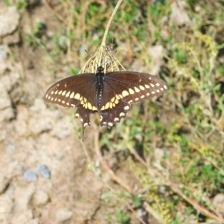

In [15]:
# Check the shapes that the mapping gave us
print("Shapes:")
print(butterfly_ds)
print()
image, label = next(iter(butterfly_ds))
print("image shape:", image.shape)
print("label shape:", label.shape, "\t\t\t", label)
print()
print(butterfly_classes[tf.argmax(label)].numpy().decode('UTF-8'))
display.display(tf.keras.utils.array_to_img(image.numpy()))


### <u>Load</u>

We first batch the datasets and then they will be loaded by the TensorFlow model.fit() method.

In [16]:
# Batch and prefetch the datasets now
train_ds = train_ds.shuffle(train_count)
train_ds = train_ds.batch(BATCH_SIZE)
# train_ds = train_ds.prefetch(AUTOTUNE)

eval_ds = eval_ds.batch(BATCH_SIZE)
eval_ds = eval_ds.prefetch(AUTOTUNE)

We can confirm the dataset is ready by taking a peek at the first batch.

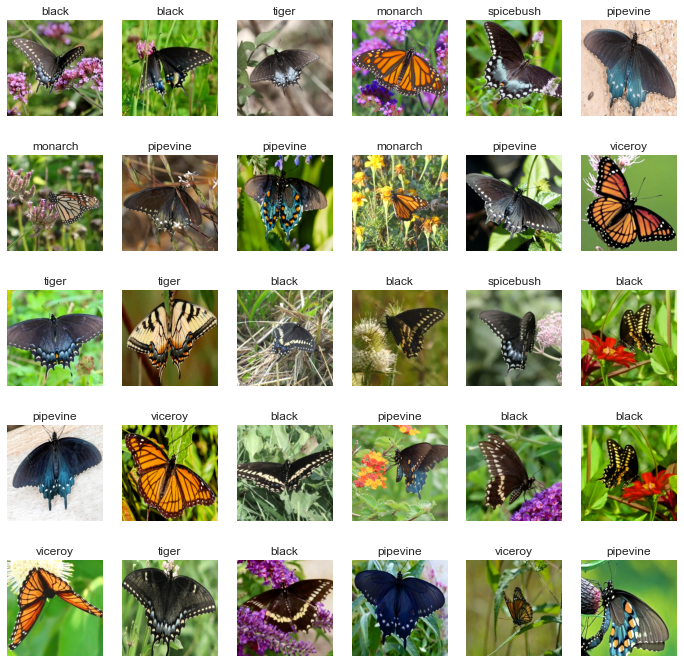

In [17]:
plt.figure(figsize=(12,12))

# Get the first batch
image_batch, label_batch = next(iter(train_ds.shuffle(train_count,reshuffle_each_iteration=True)))

rows = 5
cols = 6
for i in range(rows*cols):
    butterfly_image = tf.keras.utils.array_to_img(image_batch[i].numpy())
    butterfly_label = butterfly_classes[tf.argmax(label_batch[i])].numpy().decode('UTF-8')

    ax = plt.subplot(rows, cols, i+1)
    plt.imshow(butterfly_image)
    plt.title(butterfly_label)
    plt.axis("off")


---
## Train the Model
---

We will compile() and fit() to train our model with given dataset.

In [18]:
stop_early = EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=50,
    verbose=1,
    mode='auto',
    restore_best_weights=True
)


headless_efficientnet.trainable = True  # Don't freeze weights in all layers

butterfly_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.categorical_crossentropy,
    metrics=['accuracy'])

fit_history = butterfly_model.fit(
    train_ds,
    shuffle=True,
    epochs=NUMBER_OF_EPOCHS,
    callbacks=[stop_early],
    validation_data=eval_ds,
    verbose=1
)


Epoch 1/20
12/12 [==============================] - 60s 3s/step - loss: 1.6935 - accuracy: 0.2924 - val_loss: 1.2368 - val_accuracy: 0.6071
Epoch 2/20
12/12 [==============================] - 18s 2s/step - loss: 0.9676 - accuracy: 0.6883 - val_loss: 0.6068 - val_accuracy: 0.8062
Epoch 3/20
12/12 [==============================] - 18s 2s/step - loss: 0.4850 - accuracy: 0.8248 - val_loss: 0.3687 - val_accuracy: 0.8812
Epoch 4/20
12/12 [==============================] - 19s 2s/step - loss: 0.2525 - accuracy: 0.9269 - val_loss: 0.2723 - val_accuracy: 0.9080
Epoch 5/20
12/12 [==============================] - 18s 2s/step - loss: 0.1908 - accuracy: 0.9393 - val_loss: 0.2052 - val_accuracy: 0.9314
Epoch 6/20
12/12 [==============================] - 18s 2s/step - loss: 0.0862 - accuracy: 0.9807 - val_loss: 0.1770 - val_accuracy: 0.9412
Epoch 7/20
12/12 [==============================] - 18s 2s/step - loss: 0.0901 - accuracy: 0.9766 - val_loss: 0.1577 - val_accuracy: 0.9486
Epoch 8/20
12/12 [==

---
## Visualize the Training
---

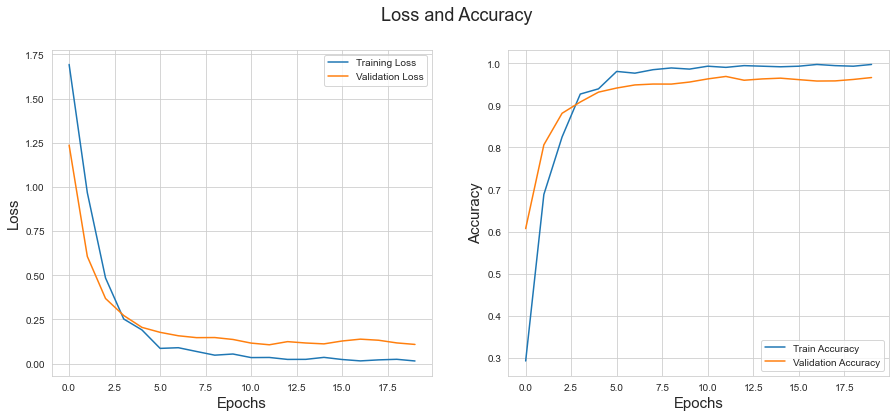

In [19]:
plt.figure(figsize=(15,6))

plt.suptitle('Loss and Accuracy', fontsize=18)

# Visualize Loss vs Epochs
plt.subplot(1,2,1)
plt.plot(fit_history.history['loss'], label='Training Loss')
plt.plot(fit_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)

# Visualize Accuracy vs Epochs
plt.subplot(1,2,2)
plt.plot(fit_history.history['accuracy'], label='Train Accuracy')
plt.plot(fit_history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.show()

---
## Evaluate the Model
---

In [20]:
# With a dataset batch we can evaluate the fitted model
model_loss, model_accuracy = butterfly_model.evaluate(eval_ds, batch_size=10)

149/149 [==============================] - 16s 103ms/step - loss: 0.1077 - accuracy: 0.9659


In [21]:
predicted_batch = butterfly_model.predict(eval_ds)

predicted_ids = tf.squeeze(predicted_batch).numpy()
predicted_labels = np.argmax(predicted_ids, axis=-1)

val_image_batch, val_label_batch = next(iter(eval_ds.take(1)))

---
## Visualize Results
---

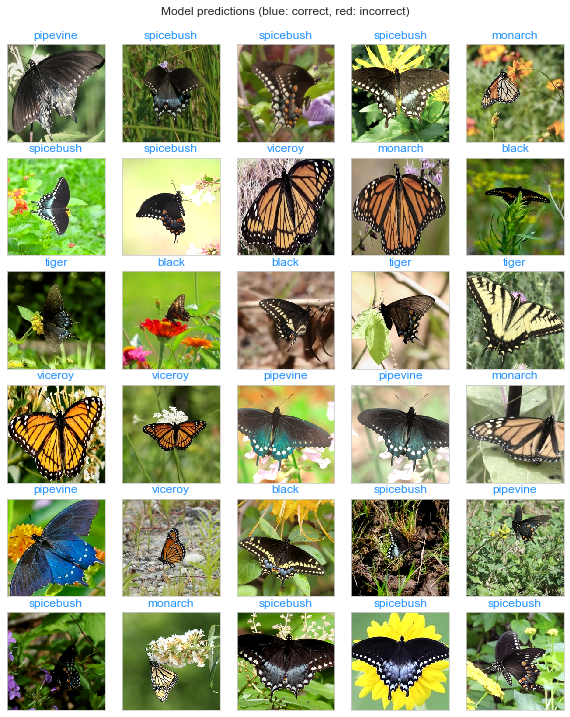

In [22]:
rows = 6
cols = 5

fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(8, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

plt.suptitle("Model predictions (blue: correct, red: incorrect)\n\n")

for n, ax in enumerate(axs.flat):
    butterfly_image = tf.keras.utils.array_to_img(val_image_batch[n].numpy())
    predicted_label = predicted_labels[n].numpy()
    actual_label = np.argmax(val_label_batch[n]).numpy()
    butterfly_label = butterfly_classes[predicted_label].numpy().decode('UTF-8')
    actual_butterfly_label = butterfly_classes[actual_label].numpy().decode('UTF-8')

    color = "dodgerblue" if predicted_label == actual_label else "crimson"
    label = actual_butterfly_label if predicted_label == actual_label else butterfly_label

    ax.imshow(butterfly_image, interpolation='none', alpha=1.0)
    ax.set_title(label, color=color)

plt.tight_layout(pad=.25)
plt.show()


In [23]:
tf.keras.backend.clear_session()

---
## Next Steps
---

The results are stellar. However, still room for improvement. Some things to try:
 - Use a better base model or roll-your-own model
 - Fine-tune the model
 - Add more augmented images
 - Improve the classifier